# Evaluando modelos de Machine Learning sobre un dataset de Spotify


La temática a analizar en este caso será el catálogo del servicio de streaming de música Spotify.
Nuestro Dataset cuenta con el título de la canción, el género, el artista, la duración, la popularidad,
la fecha de lanzamiento, el tempo, y una serie de categorías que refieren a atributos como
“bailabilidad” (danceability), “instrumentalidad” (instrumentalness), entre otros (speechiness,
acousticness, liveness, laudness, energy).
Spotify Premium cuenta con la posibilidad de ajustar una búsqueda de canciones utilizando
estos atributos denominados “audio features”. Éstos son explicados en el Blog para desarrolladores
de la plataforma de la siguiente forma:
* Acousticness: Una medida del 0.0 al 1.0 sobre si la canción es acústica. 1.0 representa que con alta confianza la canción es acústica.
* Danceability: Describe qué tan adecuada es una canción para bailar basado en una combinación de elementos musicales incluido el tempo, la estabilidad del ritmo, la fuerza del “beat”, y una regularidad general. Un valor de 0.0 es menos bailable y 1.0 es muy bailable.
* Energy: Es una medida de 0.0 a 1.0 y representa una percepción de la intensidad y la actividad. Típicamente, las canciones energéticas se sienten rápidas, fuertes y ruidosas.
* Instrumentalness: Predice si una canción no contiene palabras cantadas. “Ooh” y “aah” son tratadas como instrumentos en este contexto. El rap y la palabra hablada son consideradas como palabras cantadas. Cuanto más cerca esté el valor a 1.0, más probabilidad hay de que la canción no contenga palabras cantadas. Los valores arriba de 0.5 pretenden representar canciones instrumentales, pero la confianza es mayor a medida de que el valor se acerca a 1.0.
* Liveness: Detecta la presencia de una audiencia en la grabación. Valores más altos representan una probabilidad incrementada de que la canción fue tocada en vivo. Un valor arriba de 0.8 provee alta probabilidad de que la canción sea “en vivo”.
* Speechiness: Detecta la presencia de palabras habladas en una canción. Cuanto más exclusivamente “hablada” es la grabación (libro audible, poesía, etc.), más cercano a 1.0 será el valor del atributo. Valores arriba de 0.66 describen grabaciones que probablemente estén totalmente hechos de palabras habladas. Valores entre 0.33 y 0.66 describen grabaciones que pueden contener tanto música como palabra hablada, sea en secciones o en capas, incluido el caso del rap. Valores debajo de 0.33 más probablemente representan música u otras grabaciones no habladas.
* Tempo: El tempo general estimado de una canción en “beats” por minuto (BPM). En términos musicales, el tempo es la velocidad o el pulso de una pieza y deriva directamente del promedio de duración del “beat”.
* Valence: Una medida entre 0.0 y 1.0 que describe la “positividad musical” que transmite la canción. Canciones con valores altos suenan más “positivas” (felices, eufóricas, etc.), mientras que canciones con valores bajos suenan más “negativas” (tristes, deprimentes, enojadas, etc.).
* Loudness: Lo “fuerte” que suena en promedio una canción en decibels (dB). Los valores son promediados sobre toda la canción y son útiles para comparar entre canciones. Refiere a la cualidad de un sonido como correlato psicológico primario de “fuerza física” (amplitud). Los valores típicamente están en el rango entre -60 y 0 dB.
* Key: La clave musical en la que está la canción. Cada clave está representada por un entero: 0 = C, 1 = C♯/D♭, 2 = D, etc. Si no se detectó una clave, el valor es -1.
* Time Signature: Una métrica de tiempo estimada. Es una convención de notación para especificar cuántos “beats” hay en cada compás. Tiene un rango entre 3 y 7, indicando métricas de “3/4” a “7/4”.
* Mode: El modo indica la modalidad (mayor o menor) de una canción, el tipo de escala de la cual deriva su contenido melódico. Mayor es representado por un 1 y menor por un 0.

In [74]:
import os
import logging
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, Ridge  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

In [75]:
# Se importa el dataset
df = pd.read_excel("spotify_dataset_clean.xlsx", index_col=[0])

In [76]:
df.head()

,Genre,Title,Artist,duration_ms,explicit,popularity,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,years_since_release
0,rock,Baba O'Riley,The Who,300400,not explicit content,75,1971-08-14,0.489,0.724,5,-8.367,1,0.0352,0.31300,0.185000,0.2870,0.150,117.292,4,1971,51
1,rock,More Than a Feeling,Boston,285133,not explicit content,78,1976-01-01,0.377,0.681,7,-8.039,1,0.0298,0.00088,0.002300,0.0504,0.285,108.789,4,1976,46
2,rock,(Don't Fear) The Reaper,Blue Öyster Cult,308120,not explicit content,76,1976-01-01,0.333,0.927,9,-8.550,0,0.0733,0.00290,0.000208,0.2970,0.385,141.466,4,1976,46
3,rock,Jump - 2015 Remaster,Van Halen,241599,not explicit content,78,1984-01-04,0.572,0.835,0,-6.219,1,0.0317,0.17100,0.000377,0.0702,0.795,129.981,4,1984,38
4,rock,Stairway to Heaven - Remaster,Led Zeppelin,482830,not explicit content,79,1971-11-08,0.338,0.340,9,-12.049,0,0.0339,0.58000,0.003200,0.1160,0.197,82.433,4,1971,50


In [77]:
pd.options.display.max_columns = None
df.corr()

,duration_ms,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,years_since_release
duration_ms,1.000000,-0.110464,-0.130580,-0.063360,-0.005031,-0.206283,-0.005072,-0.028719,-0.004868,0.038689,-0.006185,-0.032985,-0.024118,-0.012847,-0.367076,0.367817
popularity,-0.110464,1.000000,-0.062691,-0.104808,-0.017899,0.016864,0.044285,-0.115127,0.088127,-0.083625,-0.040444,-0.036714,0.024585,-0.040695,0.041772,-0.043171
danceability,-0.130580,-0.062691,1.000000,-0.061862,0.032244,0.028832,-0.083561,0.256635,-0.055352,-0.093488,-0.065319,0.374979,-0.222061,0.131953,0.166012,-0.165709
energy,-0.063360,-0.104808,-0.061862,1.000000,0.019065,0.619805,-0.052318,0.043449,-0.507323,0.138314,0.139279,0.232795,0.118254,0.116490,0.048549,-0.048312
key,-0.005031,-0.017899,0.032244,0.019065,1.000000,0.002125,-0.177000,0.048737,-0.013023,0.000937,0.029306,0.032121,-0.024355,-0.001985,0.013502,-0.013862
loudness,-0.206283,0.016864,0.028832,0.619805,0.002125,1.000000,-0.053589,0.011744,-0.273857,0.006200,0.051528,0.028985,0.086457,0.051837,0.424148,-0.423826
mode,-0.005072,0.044285,-0.083561,-0.052318,-0.177000,-0.053589,1.000000,-0.088372,0.078862,-0.022262,-0.021229,-0.029808,0.021466,-0.029571,-0.078135,0.078139
speechiness,-0.028719,-0.115127,0.256635,0.043449,0.048737,0.011744,-0.088372,1.000000,-0.082577,-0.087721,0.089276,0.091846,-0.024696,0.052045,0.083298,-0.083902
acousticness,-0.004868,0.088127,-0.055352,-0.507323,-0.013023,-0.273857,0.078862,-0.082577,1.000000,-0.125792,-0.066225,-0.038097,-0.069662,-0.095495,-0.021203,0.020369
instrumentalness,0.038689,-0.083625,-0.093488,0.138314,0.000937,0.006200,-0.022262,-0.087721,-0.125792,1.000000,0.025147,-0.156503,0.046111,-0.013288,0.028815,-0.029554


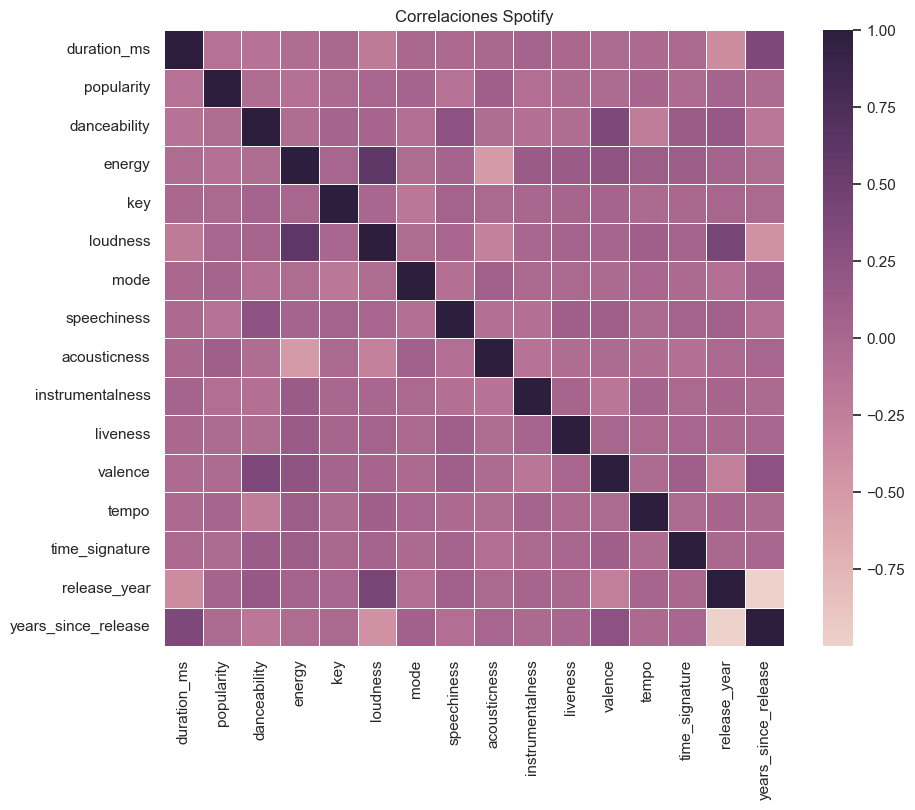

In [78]:
# Feature selection por método de correlación
plt.figure(figsize=(10,8))
sns.heatmap(data=df.corr(), cmap=sns.cubehelix_palette(as_cmap=True), linewidth=.5)
plt.title("Correlaciones Spotify")
plt.show()

* No se observan correlaciones muy fuertes. 
* Tomaremos aquellas que pueden llegar a dar algún resultado más significativo: loudness-energy y loudness-release_year.

### 1. Primera ronda de entrenamiento:

In [79]:
# Se entrena el modelo con una variable
x = df['energy'].values.reshape(-1, 1)
y = df['loudness'].values.reshape(-1, 1)

In [80]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.3, random_state=0)

In [81]:
regressor = LinearRegression()
regressor.fit(X_train, Y_train) #Creates model

LinearRegression()

Text(0.5, 0.98, 'Linear Regression Model')

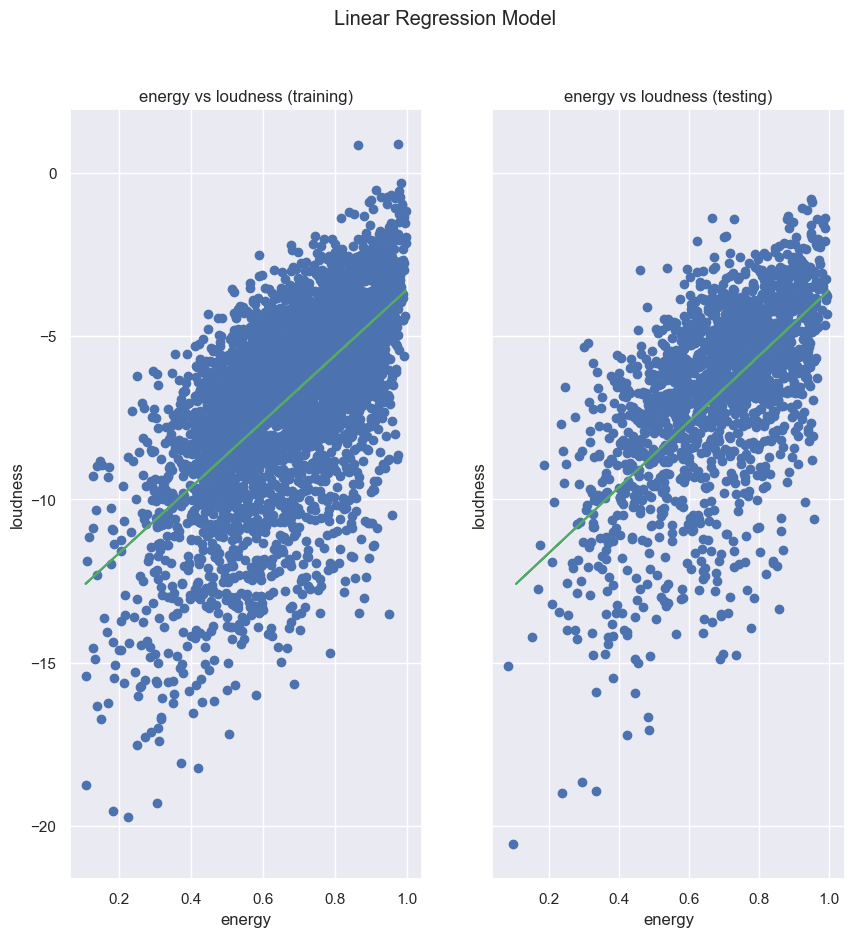

In [82]:
sns.set_theme()
fig, ax = plt.subplots(1, 2, figsize=(10, 10), sharey=True)
ax[0].scatter(X_train, Y_train)
ax[0].plot(X_train, regressor.predict(X_train), c='g')
ax[0].set_title('energy vs loudness (training)')
ax[0].set_xlabel('energy')
ax[0].set_ylabel('loudness')
ax[1].scatter(X_test, Y_test)
ax[1].plot(X_train, regressor.predict(X_train), c='g')
ax[1].set_title('energy vs loudness (testing)')
ax[1].set_xlabel('energy')
ax[1].set_ylabel('loudness')
plt.suptitle('Linear Regression Model')

In [83]:
regressor.score(X_test, Y_test)

0.3536670609050725

* Cuanto más cercano a 1 sea este valor, más precisas serán las predicciones.

In [84]:
# En este caso con dos variables
xx = df[['energy', 'release_year']].values
yy = df['loudness'].values.reshape(-1, 1)
XX_train, XX_test, YY_train, YY_test = train_test_split(xx, yy, test_size=0.3, random_state=0)
regressor.fit(XX_train, YY_train)
regressor.score(XX_test, YY_test)

0.506364392308893

* Agregando una variable más logramos un mejor resultado, aunque seguimos lejos de un score ideal.

In [85]:
# Lista con los regresores
regresores = [ 
    KNeighborsRegressor()
    ,Lasso()
    ,LGBMRegressor(objective='regression', linear_tree=True)
    ,LinearRegression()
    ,MLPRegressor(max_iter=600, random_state=170162)
    ,RandomForestRegressor(criterion='absolute_error', random_state=170162) 
    ,Ridge()
    ,SVR(gamma='auto', kernel='rbf') 
    ,XGBRegressor()
    ]

In [86]:
# Se crea una lista para las métricas
error_metrics=[]

# Se itera sobre la lista de regresores
for regresor in regresores:
    
    # Se entrena el regresor con los conjuntos de training
    regresor.fit(X_train, Y_train)
    print("-------------",type(regresor).__name__,"----------------")
    print("Training score:",regresor.score(X_train,Y_train))
    print("Testing score:",regresor.score(X_test,Y_test))
        
    # Se predice con los valores de XX_test
    y_pred = regresor.predict(X_test)
    
    # Se calcula error
    error_metrics.append( {
                           'Regresor': type(regresor).__name__, 
                           'MAE': np.sqrt(mean_absolute_error((Y_test),(y_pred))),
                           'R2': np.sqrt(r2_score((Y_test),(y_pred))),
                           'MAPE': np.sqrt(mean_absolute_percentage_error((Y_test),(y_pred)))
                          }
                        )

    
# Se convierte la lista de métricas en un dataframe
metrics_df1 = pd.DataFrame.from_dict(error_metrics)
metrics_df1.head()

------------- KNeighborsRegressor ----------------
Training score: 0.4468383333135686
Testing score: 0.22183541483974378
------------- Lasso ----------------
Training score: 0.0
Testing score: -0.0032626222768794566


C:\Users\giord\AppData\Local\Temp\ipykernel_5840\2272855213.py:20: RuntimeWarning: invalid value encountered in sqrt
  'R2': np.sqrt(r2_score((Y_test),(y_pred))),
C:\Users\giord\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------- LGBMRegressor ----------------
Training score: 0.43731253367768164
Testing score: 0.31978200376599464
------------- LinearRegression ----------------
Training score: 0.3955855414399799
Testing score: 0.3536670609050725


C:\Users\giord\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------- MLPRegressor ----------------
Training score: 0.3955117401898094
Testing score: 0.3531573116752359


C:\Users\giord\AppData\Local\Temp\ipykernel_5840\2272855213.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regresor.fit(X_train, Y_train)


------------- RandomForestRegressor ----------------
Training score: 0.48880856440469256
Testing score: 0.2509917030120705
------------- Ridge ----------------
Training score: 0.39556143994195514
Testing score: 0.354022782267261


C:\Users\giord\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------- SVR ----------------
Training score: 0.3754926361613764
Testing score: 0.3478673801629403
------------- XGBRegressor ----------------
Training score: 0.4967609209566407
Testing score: 0.2774913202328545


,Regresor,MAE,R2,MAPE
0,KNeighborsRegressor,1.362847,0.470994,0.576073
1,Lasso,1.461705,NaN,0.641855
2,LGBMRegressor,1.312010,0.565493,0.555194
3,LinearRegression,1.300420,0.594699,0.550067
4,MLPRegressor,1.301559,0.594270,0.551302


<AxesSubplot:title={'center':'Comparación de regresores (MAE)'}, xlabel='Regresor'>

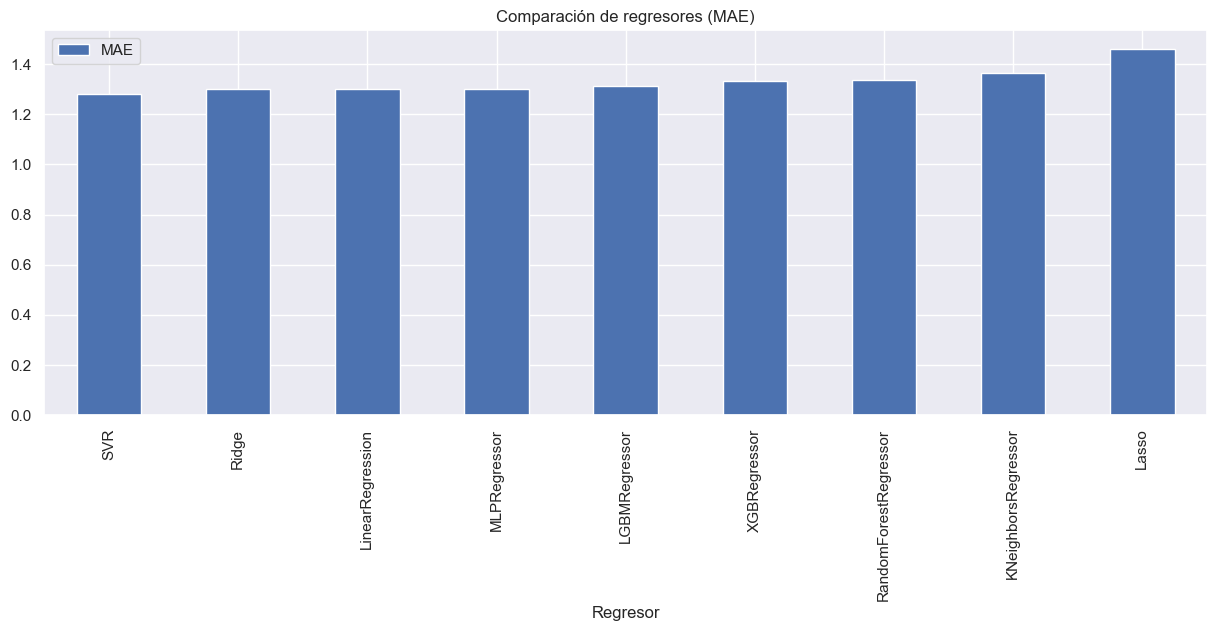

In [87]:
metrics_df1.sort_values('MAE')[['Regresor', 'MAE']].plot(figsize=(15,5)
                                                                       ,grid=True
                                                                       ,kind='bar'
                                                                       ,x='Regresor'
                                                                       ,title='Comparación de regresores (MAE)',
)

<AxesSubplot:title={'center':'Comparación de regresores (MAPE)'}, xlabel='Regresor'>

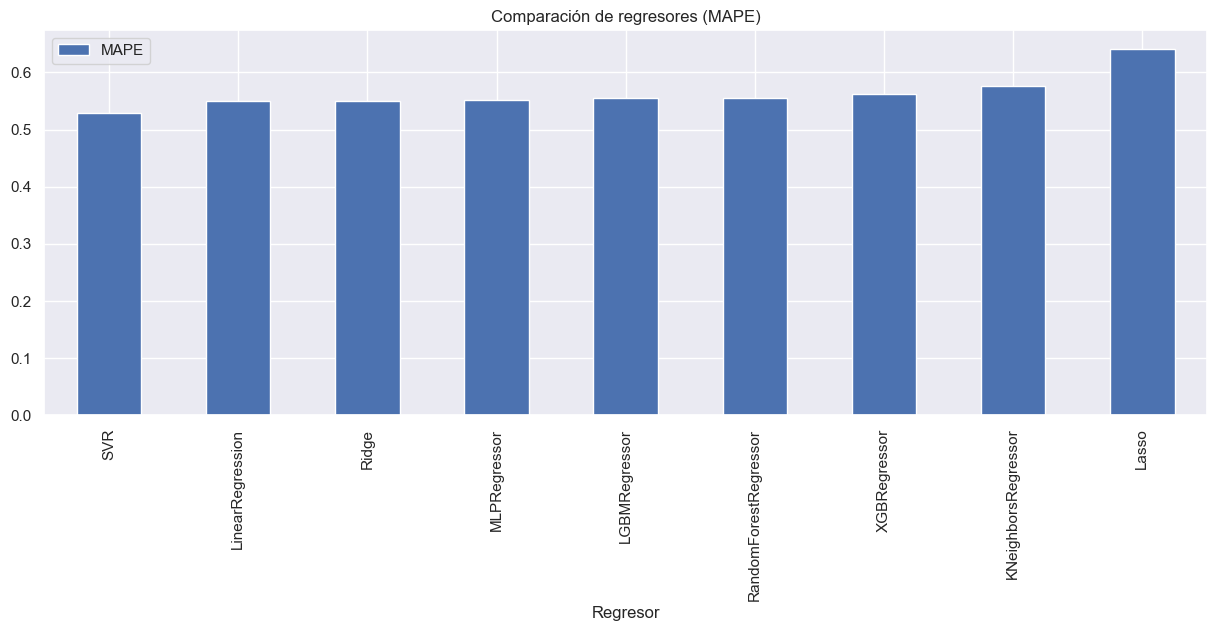

In [88]:
metrics_df1.sort_values('MAPE')[['Regresor', 'MAPE']].plot(figsize=(15,5)
                                                                       ,grid=True
                                                                       ,kind='bar'
                                                                       ,x='Regresor'
                                                                       ,title='Comparación de regresores (MAPE)',
)

<AxesSubplot:title={'center':'Comparación de regresores (R2)'}, xlabel='Regresor'>

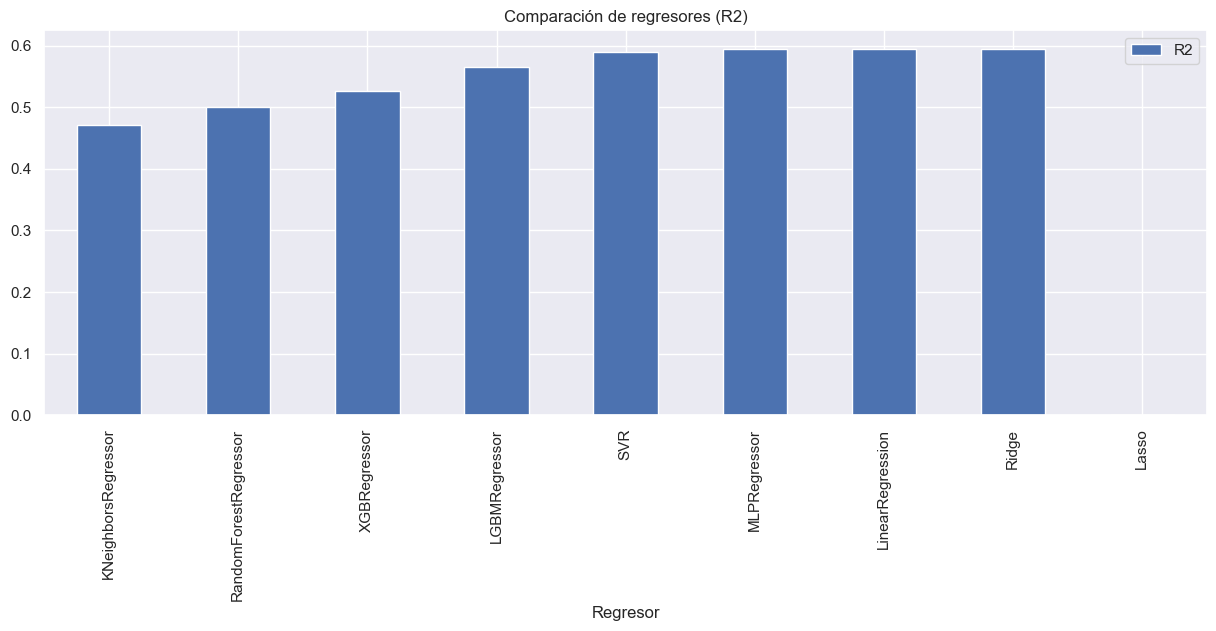

In [89]:
metrics_df1.sort_values('R2')[['Regresor', 'R2']].plot(figsize=(15,5)
                                                                       ,grid=True
                                                                       ,kind='bar'
                                                                       ,x='Regresor'
                                                                       ,title='Comparación de regresores (R2)',
)

In [90]:
metrics_df1.sort_values('MAE')[['Regresor','MAE','MAPE','R2']].style.set_properties(**{'text-align': 'left'})

,Regresor,MAE,MAPE,R2
7,SVR,1.281405,0.528740,0.589803
6,Ridge,1.300249,0.550289,0.594998
3,LinearRegression,1.300420,0.550067,0.594699
4,MLPRegressor,1.301559,0.551302,0.594270
2,LGBMRegressor,1.312010,0.555194,0.565493
8,XGBRegressor,1.331480,0.561839,0.526774
5,RandomForestRegressor,1.336982,0.555513,0.500991
0,KNeighborsRegressor,1.362847,0.576073,0.470994
1,Lasso,1.461705,0.641855,nan


* Luego de entrenar y testear varios modelos de regresión se observa que el modelo SVR es el que mejores resultados arrojó y que mejor se ajustó. Vemos que el Error Absoluto Medio para este da alrededor de 1.28, que el Error Porcentual Absoluto Medio es menor al 0.53%, y que el R2 da 0.58. 
* Sin embargo, estos resultados no indican un muy buen ajuste en el modelo, no siendo muy fiable para la predicción.

### 2. Segunda ronda de entrenamiento:

In [108]:
# En este caso con dos variables
xx = df[['energy', 'release_year', 'danceability', 'valence', 'duration_ms']].values
yy = df['loudness'].values.reshape(-1, 1)
XX_train, XX_test, YY_train, YY_test = train_test_split(xx, yy, test_size=0.3, random_state=0)
regressor.fit(XX_train, YY_train)
regressor.score(XX_test, YY_test)

0.5065868308320817

In [109]:
# Lista con los regresores
regresores = [ 
    KNeighborsRegressor()
    ,Lasso()
    ,LGBMRegressor(objective='regression', linear_tree=True)
    ,LinearRegression()
    ,MLPRegressor(max_iter=600, random_state=170162)
    ,RandomForestRegressor(criterion='absolute_error', random_state=170162) 
    ,Ridge()
    ,SVR(gamma='auto', kernel='rbf') 
    ,XGBRegressor()
    ]

In [110]:
# Se crea una lista para las métricas
error_metrics=[]

# Se itera sobre la lista de regresores
for regresor in regresores:
    
    # Se entrena el regresor con los conjuntos de training
    regresor.fit(X_train, Y_train)
    print("-------------",type(regresor).__name__,"----------------")
    print("Training score:",regresor.score(X_train,Y_train))
    print("Testing score:",regresor.score(X_test,Y_test))
        
    # Se predice con los valores de XX_test
    y_pred = regresor.predict(X_test)
    
    # Se calcula error
    error_metrics.append( {
                           'Regresor': type(regresor).__name__, 
                           'MAE': np.sqrt(mean_absolute_error((Y_test),(y_pred))),
                           'R2': np.sqrt(r2_score((Y_test),(y_pred))),
                           'MAPE': np.sqrt(mean_absolute_percentage_error((Y_test),(y_pred)))
                          }
                        )

    
# Se convierte la lista de métricas en un dataframe
metrics_df1 = pd.DataFrame.from_dict(error_metrics)
metrics_df1.head()

------------- KNeighborsRegressor ----------------
Training score: 0.4468383333135686
Testing score: 0.22183541483974378
------------- Lasso ----------------
Training score: 0.0
Testing score: -0.0032626222768794566


C:\Users\giord\AppData\Local\Temp\ipykernel_5840\2272855213.py:20: RuntimeWarning: invalid value encountered in sqrt
  'R2': np.sqrt(r2_score((Y_test),(y_pred))),
C:\Users\giord\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------- LGBMRegressor ----------------
Training score: 0.43731253367768164
Testing score: 0.31978200376599464
------------- LinearRegression ----------------
Training score: 0.3955855414399799
Testing score: 0.3536670609050725


C:\Users\giord\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------- MLPRegressor ----------------
Training score: 0.3955117401898094
Testing score: 0.3531573116752359


C:\Users\giord\AppData\Local\Temp\ipykernel_5840\2272855213.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regresor.fit(X_train, Y_train)


------------- RandomForestRegressor ----------------
Training score: 0.48880856440469256
Testing score: 0.2509917030120705
------------- Ridge ----------------
Training score: 0.39556143994195514
Testing score: 0.354022782267261


C:\Users\giord\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------- SVR ----------------
Training score: 0.3754926361613764
Testing score: 0.3478673801629403
------------- XGBRegressor ----------------
Training score: 0.4967609209566407
Testing score: 0.2774913202328545


,Regresor,MAE,R2,MAPE
0,KNeighborsRegressor,1.362847,0.470994,0.576073
1,Lasso,1.461705,NaN,0.641855
2,LGBMRegressor,1.312010,0.565493,0.555194
3,LinearRegression,1.300420,0.594699,0.550067
4,MLPRegressor,1.301559,0.594270,0.551302


<AxesSubplot:title={'center':'Comparación de regresores (MAE)'}, xlabel='Regresor'>

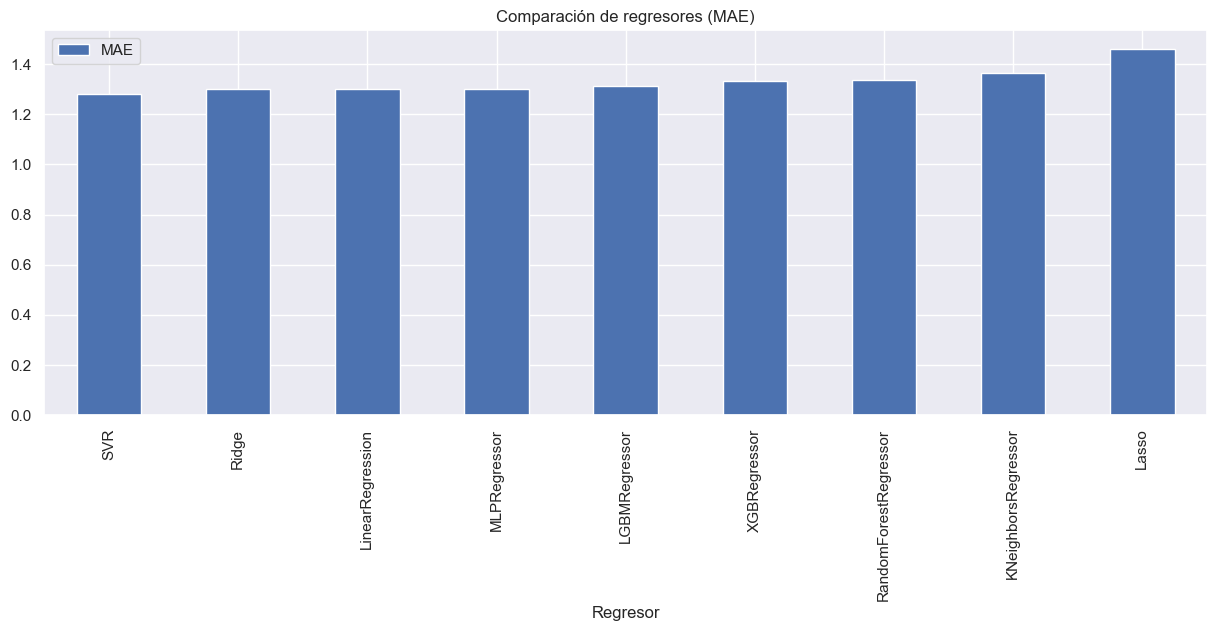

In [111]:
metrics_df1.sort_values('MAE')[['Regresor', 'MAE']].plot(figsize=(15,5)
                                                                       ,grid=True
                                                                       ,kind='bar'
                                                                       ,x='Regresor'
                                                                       ,title='Comparación de regresores (MAE)',
)

<AxesSubplot:title={'center':'Comparación de regresores (MAPE)'}, xlabel='Regresor'>

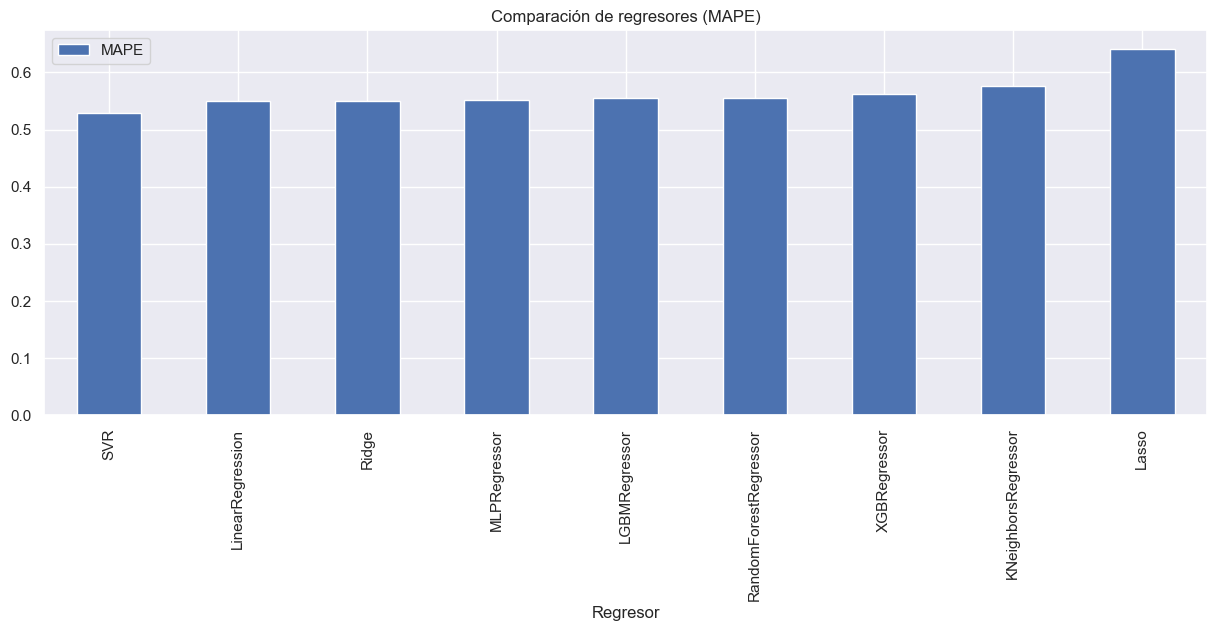

In [112]:
metrics_df1.sort_values('MAPE')[['Regresor', 'MAPE']].plot(figsize=(15,5)
                                                                       ,grid=True
                                                                       ,kind='bar'
                                                                       ,x='Regresor'
                                                                       ,title='Comparación de regresores (MAPE)',
)

<AxesSubplot:title={'center':'Comparación de regresores (R2)'}, xlabel='Regresor'>

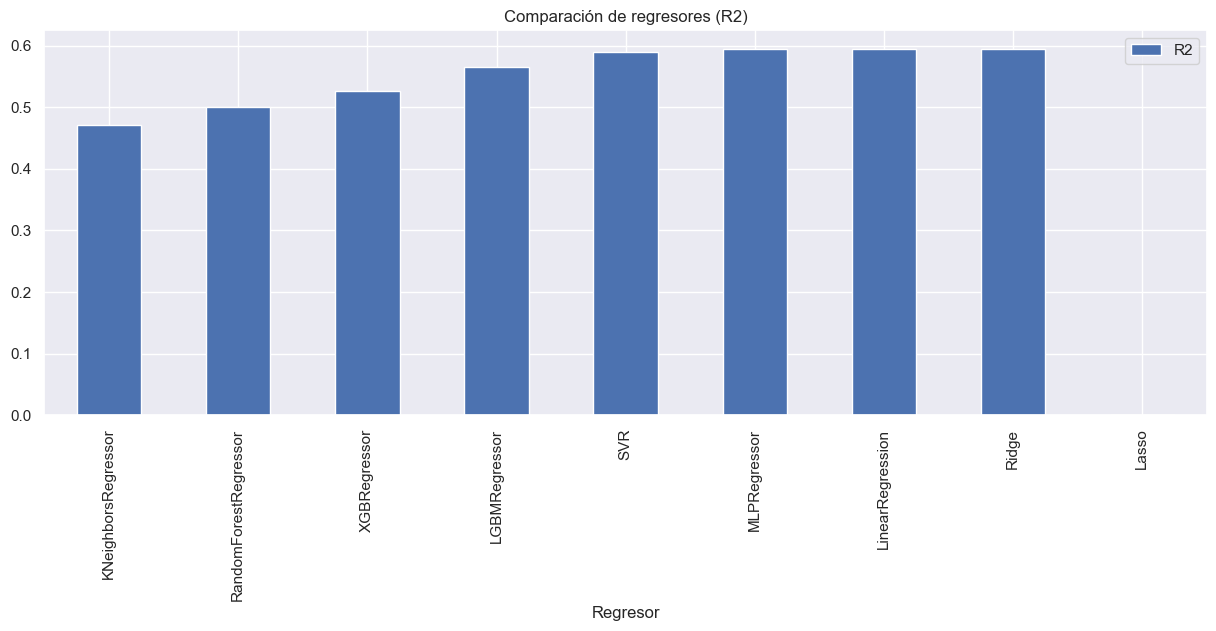

In [113]:
metrics_df1.sort_values('R2')[['Regresor', 'R2']].plot(figsize=(15,5)
                                                                       ,grid=True
                                                                       ,kind='bar'
                                                                       ,x='Regresor'
                                                                       ,title='Comparación de regresores (R2)',
)

In [114]:
metrics_df1.sort_values('MAE')[['Regresor','MAE','MAPE','R2']].style.set_properties(**{'text-align': 'left'})

,Regresor,MAE,MAPE,R2
7,SVR,1.281405,0.528740,0.589803
6,Ridge,1.300249,0.550289,0.594998
3,LinearRegression,1.300420,0.550067,0.594699
4,MLPRegressor,1.301559,0.551302,0.594270
2,LGBMRegressor,1.312010,0.555194,0.565493
8,XGBRegressor,1.331480,0.561839,0.526774
5,RandomForestRegressor,1.336982,0.555513,0.500991
0,KNeighborsRegressor,1.362847,0.576073,0.470994
1,Lasso,1.461705,0.641855,nan


* Luego de esta segunda ronda de entrenamiento, donde testeamos varios modelos de regresión, se observan resultados prácticamente idénticos. El modelo SVR nuevamente es el que mejores resultados arrojó y que mejor se ajustó. Vemos que el Error Absoluto Medio para este da alrededor de 1.28, que el Error Porcentual Absoluto Medio es menor al 0.53%, y que el R2 da 0.58. 
* Nuevamente encongtramos que estos resultados no indican un muy buen ajuste en el modelo, no siendo muy fiable para la predicción.